In [1]:
#import pandas_profiling
#!pip install bayesian-optimization
from bayes_opt import BayesianOptimization
import category_encoders as ce
import gzip
import matplotlib as mpb
import numpy as np
import pandas as pd
import pickle
from sklearn.compose import ColumnTransformer
import xgboost as xgb

In [2]:
detailed_listing = 'http://data.insideairbnb.com/united-states/ca/los-angeles/2019-12-05/data/listings.csv.gz'
summary_listing = 'http://data.insideairbnb.com/united-states/ca/los-angeles/2019-12-05/visualisations/listings.csv'

In [3]:
det_list = pd.read_csv(detailed_listing, compression='gzip', error_bad_lines=False, warn_bad_lines=False)

print(det_list.shape)
det_list.head()

d:\csfiles\lambda\git\airbnb3\airenv\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (43,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(40125, 106)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,109,https://www.airbnb.com/rooms/109,20191205175409,2019-12-06,Amazing bright elegant condo park front *UPGRA...,"*** Unit upgraded with new bamboo flooring, br...","*** Unit upgraded with new bamboo flooring, br...","*** Unit upgraded with new bamboo flooring, br...",none,NaN,...,f,f,strict_14_with_grace_period,t,f,1,1,0,0,0.02
1,344,https://www.airbnb.com/rooms/344,20191205175409,2019-12-06,Family perfect;Pool;Near Studios!,This home is perfect for families; aspiring ch...,"Cheerful & comfortable; near studios, amusemen...",This home is perfect for families; aspiring ch...,none,Quiet-yet-close to all the fun in LA! Hollywoo...,...,t,f,flexible,f,f,1,1,0,0,0.19
2,2708,https://www.airbnb.com/rooms/2708,20191205175409,2019-12-06,Mirrored Mini-Suite with Fireplace - W. Hollywood,Our best memory foam pillows you'll ever sleep...,Flickering fireplace. Blendtec® Designer 625 ...,Our best memory foam pillows you'll ever sleep...,none,We are minutes away from the Mentor Language I...,...,t,f,strict_14_with_grace_period,f,f,2,0,2,0,0.33
3,2732,https://www.airbnb.com/rooms/2732,20191205175409,2019-12-06,Zen Life at the Beach,NaN,This is a three story townhouse with the follo...,This is a three story townhouse with the follo...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,2,1,1,0,0.19
4,2864,https://www.airbnb.com/rooms/2864,20191205175409,2019-12-07,*Upscale Professional Home with Beautiful Studio*,Centrally located.... Furnished with 42 inch S...,The space is furnished with Thomasville furnit...,Centrally located.... Furnished with 42 inch S...,none,What makes the neighborhood unique is that the...,...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,NaN


In [4]:
summary_list = pd.read_csv(summary_listing, error_bad_lines=False, warn_bad_lines=False )

print(summary_list.shape)
summary_list.head()

(40125, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,109,Amazing bright elegant condo park front *UPGRA...,521,Paolo,Other Cities,Culver City,33.98209,-118.38494,Entire home/apt,122,30,2,2016-05-15,0.02,1,248
1,344,Family perfect;Pool;Near Studios!,767,Melissa,Other Cities,Burbank,34.16562,-118.33458,Entire home/apt,168,2,8,2019-10-19,0.19,1,62
2,2708,Mirrored Mini-Suite with Fireplace - W. Hollywood,3008,Chas.,City of Los Angeles,Hollywood,34.09768,-118.34602,Private room,79,30,22,2019-08-31,0.33,2,252
3,2732,Zen Life at the Beach,3041,Yoga Priestess,Other Cities,Santa Monica,34.00475,-118.48127,Private room,140,1,20,2019-10-03,0.19,2,344
4,2864,*Upscale Professional Home with Beautiful Studio*,3207,Bernadine,Other Cities,Bellflower,33.87619,-118.11397,Entire home/apt,80,2,0,NaN,NaN,1,0


In [5]:
list(summary_list.columns)

['id',
 'name',
 'host_id',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

In [6]:
list(det_list.columns)

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',


In [7]:
det_list.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,109,https://www.airbnb.com/rooms/109,20191205175409,2019-12-06,Amazing bright elegant condo park front *UPGRA...,"*** Unit upgraded with new bamboo flooring, br...","*** Unit upgraded with new bamboo flooring, br...","*** Unit upgraded with new bamboo flooring, br...",none,NaN,...,f,f,strict_14_with_grace_period,t,f,1,1,0,0,0.02
1,344,https://www.airbnb.com/rooms/344,20191205175409,2019-12-06,Family perfect;Pool;Near Studios!,This home is perfect for families; aspiring ch...,"Cheerful & comfortable; near studios, amusemen...",This home is perfect for families; aspiring ch...,none,Quiet-yet-close to all the fun in LA! Hollywoo...,...,t,f,flexible,f,f,1,1,0,0,0.19
2,2708,https://www.airbnb.com/rooms/2708,20191205175409,2019-12-06,Mirrored Mini-Suite with Fireplace - W. Hollywood,Our best memory foam pillows you'll ever sleep...,Flickering fireplace. Blendtec® Designer 625 ...,Our best memory foam pillows you'll ever sleep...,none,We are minutes away from the Mentor Language I...,...,t,f,strict_14_with_grace_period,f,f,2,0,2,0,0.33
3,2732,https://www.airbnb.com/rooms/2732,20191205175409,2019-12-06,Zen Life at the Beach,NaN,This is a three story townhouse with the follo...,This is a three story townhouse with the follo...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,2,1,1,0,0.19
4,2864,https://www.airbnb.com/rooms/2864,20191205175409,2019-12-07,*Upscale Professional Home with Beautiful Studio*,Centrally located.... Furnished with 42 inch S...,The space is furnished with Thomasville furnit...,Centrally located.... Furnished with 42 inch S...,none,What makes the neighborhood unique is that the...,...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,NaN


In [8]:
columns = ['price', 'beds', 'bedrooms', 'bathrooms', 'zipcode', 
           'property_type', 'room_type', 'accommodates', 'cleaning_fee',
           'guests_included',  'instant_bookable', 'amenities']

train = det_list[columns]

train.head()

,price,beds,bedrooms,bathrooms,zipcode,property_type,room_type,accommodates,cleaning_fee,guests_included,instant_bookable,amenities
0,$122.00,3.0,2.0,2.0,90230,Condominium,Entire home/apt,6,$240.00,3,f,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning..."
1,$168.00,3.0,3.0,1.0,91505,House,Entire home/apt,6,$100.00,6,t,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning..."
2,$79.00,1.0,1.0,1.5,90046,Apartment,Private room,1,$87.00,1,t,"{Internet,Wifi,""Air conditioning"",""Wheelchair ..."
3,$140.00,1.0,1.0,1.0,90405,Apartment,Private room,1,$100.00,1,f,"{Internet,Wifi,Kitchen,Heating,Washer,Dryer,""S..."
4,$80.00,1.0,1.0,1.0,90706,Apartment,Entire home/apt,2,$75.00,1,f,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning..."


In [9]:
def create_bool_from_dict(df, seriesdict, feature):
    df[feature] = df[seriesdict].str.contains(feature)
    return df[feature]

amenities_list = ['TV', 'Wifi', 'Kitchen', 'Air conditioning', 'Pool', 'Hot tub',
                  'Washer', 'Dryer', 'Regrigerator', 'Iron', 'Free parking on premises',
                 'Dishes and silverware', 'Microwave']

for x in amenities_list:
    create_bool_from_dict(train, 'amenities', x)

train.head()


d:\csfiles\lambda\git\airbnb3\airenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,price,beds,bedrooms,bathrooms,zipcode,property_type,room_type,accommodates,cleaning_fee,guests_included,...,Air conditioning,Pool,Hot tub,Washer,Dryer,Regrigerator,Iron,Free parking on premises,Dishes and silverware,Microwave
0,$122.00,3.0,2.0,2.0,90230,Condominium,Entire home/apt,6,$240.00,3,...,True,True,True,True,True,False,True,True,False,False
1,$168.00,3.0,3.0,1.0,91505,House,Entire home/apt,6,$100.00,6,...,True,True,False,True,True,False,True,False,True,True
2,$79.00,1.0,1.0,1.5,90046,Apartment,Private room,1,$87.00,1,...,True,False,True,True,True,False,True,True,True,True
3,$140.00,1.0,1.0,1.0,90405,Apartment,Private room,1,$100.00,1,...,False,False,False,True,True,False,False,False,False,False
4,$80.00,1.0,1.0,1.0,90706,Apartment,Entire home/apt,2,$75.00,1,...,True,False,True,True,True,False,False,True,False,False


In [10]:
print(train.isna().sum())

price                          0
beds                          92
bedrooms                      70
bathrooms                     25
zipcode                      464
property_type                  0
room_type                      0
accommodates                   0
cleaning_fee                5238
guests_included                0
instant_bookable               0
amenities                      0
TV                             0
Wifi                           0
Kitchen                        0
Air conditioning               0
Pool                           0
Hot tub                        0
Washer                         0
Dryer                          0
Regrigerator                   0
Iron                           0
Free parking on premises       0
Dishes and silverware          0
Microwave                      0
dtype: int64


In [11]:
train['price'] = train['price'].str.replace('$','')
train['price'] = train['price'].str.replace(',','').astype('float')

train['beds'] = train['beds'].fillna(train['beds'].mode()[0])
train['beds'] = train['beds'].astype(int)


train['zipcode'] = train['zipcode'].str.strip()
train['zipcode'] = np.where(train['zipcode'].str.contains('ca', case = False), '', train['zipcode'])
train['zipcode'] = train['zipcode'].str.replace(' ', '')
train['zipcode'] = train['zipcode'].str.replace('139SValenciaAve,Glendora.', '')
train['zipcode'] = train['zipcode'].str[:5]
train['zipcode'] = train['zipcode'].replace('',np.nan)
train['zipcode'] = train['zipcode'].astype(str)


train['cleaning_fee'] = train['cleaning_fee'].str.replace('$','')
train['cleaning_fee'] = train['cleaning_fee'].str.replace(',','')
train['cleaning_fee'] = train['cleaning_fee'].astype(float)


train['instant_bookable'] = np.where(train['instant_bookable'].str.contains('t'), 1, 0)

d:\csfiles\lambda\git\airbnb3\airenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
d:\csfiles\lambda\git\airbnb3\airenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
d:\csfiles\lambda\git\airbnb3\airenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [12]:
print(train.isna().sum())

price                          0
beds                           0
bedrooms                      70
bathrooms                     25
zipcode                        0
property_type                  0
room_type                      0
accommodates                   0
cleaning_fee                5238
guests_included                0
instant_bookable               0
amenities                      0
TV                             0
Wifi                           0
Kitchen                        0
Air conditioning               0
Pool                           0
Hot tub                        0
Washer                         0
Dryer                          0
Regrigerator                   0
Iron                           0
Free parking on premises       0
Dishes and silverware          0
Microwave                      0
dtype: int64


In [13]:
train.dtypes

price                       float64
beds                          int32
bedrooms                    float64
bathrooms                   float64
zipcode                      object
property_type                object
room_type                    object
accommodates                  int64
cleaning_fee                float64
guests_included               int64
instant_bookable              int32
amenities                    object
TV                             bool
Wifi                           bool
Kitchen                        bool
Air conditioning               bool
Pool                           bool
Hot tub                        bool
Washer                         bool
Dryer                          bool
Regrigerator                   bool
Iron                           bool
Free parking on premises       bool
Dishes and silverware          bool
Microwave                      bool
dtype: object

In [14]:
train.head()

,price,beds,bedrooms,bathrooms,zipcode,property_type,room_type,accommodates,cleaning_fee,guests_included,...,Air conditioning,Pool,Hot tub,Washer,Dryer,Regrigerator,Iron,Free parking on premises,Dishes and silverware,Microwave
0,122.0,3,2.0,2.0,90230,Condominium,Entire home/apt,6,240.0,3,...,True,True,True,True,True,False,True,True,False,False
1,168.0,3,3.0,1.0,91505,House,Entire home/apt,6,100.0,6,...,True,True,False,True,True,False,True,False,True,True
2,79.0,1,1.0,1.5,90046,Apartment,Private room,1,87.0,1,...,True,False,True,True,True,False,True,True,True,True
3,140.0,1,1.0,1.0,90405,Apartment,Private room,1,100.0,1,...,False,False,False,True,True,False,False,False,False,False
4,80.0,1,1.0,1.0,90706,Apartment,Entire home/apt,2,75.0,1,...,True,False,True,True,True,False,False,True,False,False


In [15]:
train['room_type'].value_counts()

Entire home/apt    25189
Private room       13117
Shared room         1491
Hotel room           328
Name: room_type, dtype: int64

In [16]:
# Features we want
categorical_features = ['zipcode','property_type','room_type']
numeric_features = ['price', 'beds', 'bedrooms', 'bathrooms', 'accommodates','guests_included', 'instant_bookable', 'cleaning_fee']
bool_features = ['tv', 'wifi', 'kitchen', 'air conditioning', 'pool', 'hot tub', 'washer', 'dryer', 'refrigerator', 'iron', 'free parking on premises', 'dishes and silverware', 'microwave']

# Changing all column names to lowercase
renamer = dict(zip(amenities_list, bool_features))
print(renamer)

{'TV': 'tv', 'Wifi': 'wifi', 'Kitchen': 'kitchen', 'Air conditioning': 'air conditioning', 'Pool': 'pool', 'Hot tub': 'hot tub', 'Washer': 'washer', 'Dryer': 'dryer', 'Regrigerator': 'refrigerator', 'Iron': 'iron', 'Free parking on premises': 'free parking on premises', 'Dishes and silverware': 'dishes and silverware', 'Microwave': 'microwave'}


In [17]:
train = train.rename(columns=renamer)
train.head()

,price,beds,bedrooms,bathrooms,zipcode,property_type,room_type,accommodates,cleaning_fee,guests_included,...,air conditioning,pool,hot tub,washer,dryer,refrigerator,iron,free parking on premises,dishes and silverware,microwave
0,122.0,3,2.0,2.0,90230,Condominium,Entire home/apt,6,240.0,3,...,True,True,True,True,True,False,True,True,False,False
1,168.0,3,3.0,1.0,91505,House,Entire home/apt,6,100.0,6,...,True,True,False,True,True,False,True,False,True,True
2,79.0,1,1.0,1.5,90046,Apartment,Private room,1,87.0,1,...,True,False,True,True,True,False,True,True,True,True
3,140.0,1,1.0,1.0,90405,Apartment,Private room,1,100.0,1,...,False,False,False,True,True,False,False,False,False,False
4,80.0,1,1.0,1.0,90706,Apartment,Entire home/apt,2,75.0,1,...,True,False,True,True,True,False,False,True,False,False


In [18]:
#categorical_counts = train.select_dtypes(exclude='number').nunique().sort_values()
categorical_counts = []
categorical_counts.append(train[categorical_features].nunique().sort_values())
high_cardi_cols = []
low_cardi_cols = []
for i in categorical_features:
    if train[i].nunique() > 150:
        high_cardi_cols.append(i)
    else:
        low_cardi_cols.append(i)

In [19]:
print(categorical_counts, high_cardi_cols, low_cardi_cols)

[room_type          4
property_type     44
zipcode          295
dtype: int64] ['zipcode'] ['property_type', 'room_type']


In [20]:
'''
# Not being used right now but saving for later
ct = ColumnTransformer([("oe", ce.OrdinalEncoder(), high_cardi_cols),
                        ("ohe", ce.OneHotEncoder(use_cat_names=True), low_cardi_cols)])
'''

'\n# Not being used right now but saving for later\nct = ColumnTransformer([("oe", ce.OrdinalEncoder(), high_cardi_cols),\n                        ("ohe", ce.OneHotEncoder(use_cat_names=True), low_cardi_cols)])\n'

In [21]:
# We'll impute missing values using the median for numeric columns and the most
# common value for string columns.

from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)

train = DataFrameImputer().fit_transform(train)

In [22]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
for feature in categorical_features:
    train[feature] = label_encoder.fit_transform(train[feature])

In [23]:
train.head()

,price,beds,bedrooms,bathrooms,zipcode,property_type,room_type,accommodates,cleaning_fee,guests_included,...,air conditioning,pool,hot tub,washer,dryer,refrigerator,iron,free parking on premises,dishes and silverware,microwave
0,122.0,3,2.0,2.0,77,15,0,6,240.0,3,...,True,True,True,True,True,False,True,True,False,False
1,168.0,3,3.0,1.0,229,25,0,6,100.0,6,...,True,True,False,True,True,False,True,False,True,True
2,79.0,1,1.0,1.5,50,1,2,1,87.0,1,...,True,False,True,True,True,False,True,True,True,True
3,140.0,1,1.0,1.0,113,1,2,1,100.0,1,...,False,False,False,True,True,False,False,False,False,False
4,80.0,1,1.0,1.0,133,1,0,2,75.0,1,...,True,False,True,True,True,False,False,True,False,False


In [24]:
train['price'].describe()

count    40125.000000
mean       225.840673
std        656.723597
min          0.000000
25%         70.000000
50%        110.000000
75%        189.000000
max      25000.000000
Name: price, dtype: float64

In [25]:
features = numeric_features + categorical_features + bool_features
target = 'price'
train_features = train[features]

In [26]:
train_labels = train_features['price']
train_features = train_features.drop(columns=['price'])

In [27]:
X_train = train_features
y_train = train_labels

X_train.shape, y_train.shape

((40125, 23), (40125,))

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.75, 
                                                  test_size = 0.25, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((30093, 23), (10032, 23), (30093,), (10032,))

In [29]:
from xgboost import XGBRegressor


eval_set = [(X_train, y_train), 
            (X_val, y_val)]

model = XGBRegressor(n_estimators=1000, n_jobs=-1)
model.fit(X_train, y_train, eval_set=eval_set, eval_metric='rmse', 
          early_stopping_rounds=100)



d:\csfiles\lambda\git\airbnb3\airenv\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:57:42] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:664.634	validation_1-rmse:680.207
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:641.587	validation_1-rmse:659.62
[2]	validation_0-rmse:621.986	validation_1-rmse:643.174
[3]	validation_0-rmse:603.79	validation_1-rmse:628.067
[4]	validation_0-rmse:588.374	validation_1-rmse:615.002
[5]	validation_0-rmse:574.812	validation_1-rmse:603.3
[6]	validation_0-rmse:563.858	validation_1-rmse:594.065
[7]	validation_0-rmse:553.464	validation_1-rmse:581.687
[8]	validation_0-rmse:543.999	validation_1-rmse:570.374
[9]	validation_0-rmse:535.545	validation_1-rmse:562.187
[10]	validation_0-rmse:526.773	validation_1-rmse:553.626
[11]	validation_0-rmse:519.062	validation_1-rmse:544.854
[12]	validation_0-rm

[139]	validation_0-rmse:408.409	validation_1-rmse:465.231
[140]	validation_0-rmse:408.186	validation_1-rmse:465.068
[141]	validation_0-rmse:408.145	validation_1-rmse:465.069
[142]	validation_0-rmse:407.717	validation_1-rmse:464.735
[143]	validation_0-rmse:407.526	validation_1-rmse:464.729
[144]	validation_0-rmse:407.273	validation_1-rmse:464.916
[145]	validation_0-rmse:406.498	validation_1-rmse:464.13
[146]	validation_0-rmse:406.397	validation_1-rmse:463.988
[147]	validation_0-rmse:405.803	validation_1-rmse:464.739
[148]	validation_0-rmse:405.764	validation_1-rmse:464.647
[149]	validation_0-rmse:405.707	validation_1-rmse:464.585
[150]	validation_0-rmse:405.47	validation_1-rmse:464.351
[151]	validation_0-rmse:405.288	validation_1-rmse:464.274
[152]	validation_0-rmse:405.041	validation_1-rmse:464.319
[153]	validation_0-rmse:404.562	validation_1-rmse:464.21
[154]	validation_0-rmse:404.317	validation_1-rmse:464.215
[155]	validation_0-rmse:403.982	validation_1-rmse:463.981
[156]	validation_

[281]	validation_0-rmse:380.583	validation_1-rmse:463.443
[282]	validation_0-rmse:380.529	validation_1-rmse:463.49
[283]	validation_0-rmse:380.523	validation_1-rmse:463.49
[284]	validation_0-rmse:380.257	validation_1-rmse:463.51
[285]	validation_0-rmse:380.152	validation_1-rmse:463.396
[286]	validation_0-rmse:380.105	validation_1-rmse:463.439
[287]	validation_0-rmse:379.879	validation_1-rmse:463.603
[288]	validation_0-rmse:379.644	validation_1-rmse:463.603
[289]	validation_0-rmse:379.498	validation_1-rmse:463.608
[290]	validation_0-rmse:379.392	validation_1-rmse:463.618
[291]	validation_0-rmse:379.275	validation_1-rmse:463.479
[292]	validation_0-rmse:379.266	validation_1-rmse:463.479
[293]	validation_0-rmse:379.247	validation_1-rmse:463.487
[294]	validation_0-rmse:379.093	validation_1-rmse:463.158
[295]	validation_0-rmse:379.027	validation_1-rmse:463.151
[296]	validation_0-rmse:378.95	validation_1-rmse:463.158
[297]	validation_0-rmse:378.851	validation_1-rmse:462.87
[298]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [30]:
file_name = "xgb_reg.pkl"

# save
pickle.dump(model, open(file_name, "wb"))

# load
xgb_model_loaded = pickle.load(open(file_name, "rb"))

# test
#ind = 1
#test = X_val[ind]
#xgb_model_loaded.predict(test)[0] == xgb_model.predict(test)[0]

[10:58:29] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


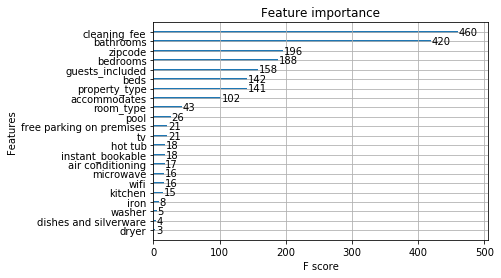

In [31]:
xgb.plot_importance(model)

In [32]:
# Convert processed data into an xgb.DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)

d:\csfiles\lambda\git\airbnb3\airenv\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [33]:
def xgb_evaluate(colsample_bytree, gamma, learning_rate, max_delta_step, max_depth_step, min_child_weight, n_estimators, subsample):
    params = {'colsample_bytree': colsample_bytree,
              'eta': 0.1,
              'eval_metric': 'rmse',
              'gamma': gamma,
              'learning_rate': learning_rate,
              'max_delta_step': max_delta_step,
              'max_depth_step': int(max_depth_step),
              'min_child_weight': min_child_weight,
              'n_estimators': n_estimators,
              'seed': 9,
              'subsample': subsample}
    # Use around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, dtrain, num_boost_round=1000, nfold=3)    
    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [34]:
'''
xgb_bo = BayesianOptimization(xgb_evaluate, {'colsample_bytree': (0.3, 1),
                                             'gamma': (0, 5),
                                             'learning_rate':(0.01,0.5),
                                             'max_delta_step': (0, 10),
                                             'max_depth_step': (1, 6),
                                             'min_child_weight':(0,5),
                                             'n_estimators':(850, 1200),
                                             'subsample': (0.4, 1.0)})
# Use the expected improvement acquisition function to handle negative numbers
# Optimally needs quite a few more initiation points and number of iterations
xgb_bo.maximize(init_points=6, n_iter=10, acq='ei')'''

"\nxgb_bo = BayesianOptimization(xgb_evaluate, {'colsample_bytree': (0.3, 1),\n                                             'gamma': (0, 5),\n                                             'learning_rate':(0.01,0.5),\n                                             'max_delta_step': (0, 10),\n                                             'max_depth_step': (1, 6),\n                                             'min_child_weight':(0,5),\n                                             'n_estimators':(850, 1200),\n                                             'subsample': (0.4, 1.0)})\n# Use the expected improvement acquisition function to handle negative numbers\n# Optimally needs quite a few more initiation points and number of iterations\nxgb_bo.maximize(init_points=6, n_iter=10, acq='ei')"

In [35]:
file_name = "xgb_reg_bo.pkl"

# save
pickle.dump(model, open(file_name, "wb"))

# load
xgb_bo_loaded = pickle.load(open(file_name, "rb"))


[10:58:31] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [36]:
'''# Write our ensemble method - train 11 models, and weight them all equally by finding the mode of the votes for each well.
# The majority vote for each well is the consensus, which will be our predictions
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import random

random.seed(42)
count = 0
score = 0
scores = 0
prediction_votes=pd.DataFrame()
for num in range(1,2):
    seed = random.randint(1,9000)
    model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1, 
                          colsample_bynode=1, colsample_bytree=1, gamma=0,
                          importance_type='gain', learning_rate=0.1, max_delta_step=0,
                          max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
                          n_jobs=-1, nthread=None, objective='reg:squarederror', random_state=0,
                          reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                          silent=None, subsample=1, verbosity=1).fit(X_train, y_train)
    predictions = model.predict(X_val)
    #score = accuracy_score(y_val, predictions)
    prediction_votes[num] = predictions
    scores += score
    count += 1
    print(score)
    y_pred_proba = model.predict_proba(X_train)[:,1]
    print('Test ROC AUC:', roc_auc_score(y_train, y_pred_proba))

print(f"The average accuracy score using these hyperparams over {count} iterations is {scores/count}")'''

'# Write our ensemble method - train 11 models, and weight them all equally by finding the mode of the votes for each well.\n# The majority vote for each well is the consensus, which will be our predictions\nfrom sklearn.metrics import roc_auc_score\nfrom sklearn.metrics import accuracy_score\nfrom sklearn.metrics import mean_squared_error\nimport random\n\nrandom.seed(42)\ncount = 0\nscore = 0\nscores = 0\nprediction_votes=pd.DataFrame()\nfor num in range(1,2):\n    seed = random.randint(1,9000)\n    model = xgb.XGBRegressor(base_score=0.5, booster=\'gbtree\', colsample_bylevel=1, \n                          colsample_bynode=1, colsample_bytree=1, gamma=0,\n                          importance_type=\'gain\', learning_rate=0.1, max_delta_step=0,\n                          max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,\n                          n_jobs=-1, nthread=None, objective=\'reg:squarederror\', random_state=0,\n                          reg_alpha=0, reg_lambda=

In [37]:
opt_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1, 
                          colsample_bynode=1, colsample_bytree=1, gamma=0,
                          importance_type='gain', learning_rate=0.1, max_delta_step=0,
                          max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
                          n_jobs=-1, nthread=None, objective='reg:squarederror', random_state=0,
                          reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                          silent=None, subsample=1, verbosity=1)
opt_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

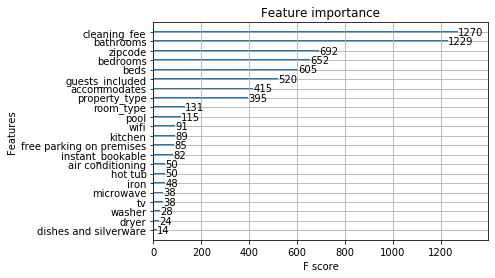

In [38]:
xgb.plot_importance(opt_model)

In [39]:
file_name = "opt_xgb_reg.pkl"

# save
pickle.dump(opt_model, open(file_name, "wb"))

In [42]:
data = pd.DataFrame.from_dict([{'beds': 2, 'bedrooms': 2.0, 'bathrooms': 1.0, 'accommodates': 2, 'guests_included': 1,
                                'instant_bookable': 0, 'cleaning_fee': 70.0, 'zipcode': 90706, 'property_type': 'Apartment', 'room_type': 'Entire home/apt', 
                                'tv': True, 'wifi': True, 'kitchen': True, 'air conditioning': True, 'pool': True,
                                'hot tub': True, 'washer': True, 'dryer': False, 'refrigerator': True, 'iron' :True, 'free parking on premises' :True,
                                'dishes and silverware': False, 'microwave': True
                  }])

def encode_data(df):
    label_encoder = LabelEncoder()
    for feature in categorical_features:
        df[feature] = label_encoder.fit_transform(df[feature])
    return df

data = encode_data(data)

In [45]:
from sklearn.metrics import mean_squared_error
opt_preds = opt_model.predict(X_val)
print(np.sqrt(mean_squared_error(y_val, opt_preds)))
print(opt_model.predict(data))


462.31411415880115
[257.7331]


In [46]:
orig_preds = model.predict(X_val)
print(np.sqrt(mean_squared_error(y_val, orig_preds)))
print(model.predict(data))

462.5507873274299
[214.13464]
